In [1]:
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import os
import socket
import time
import random
import glob
import argparse, json
import pandas as pd

from os import listdir
from os.path import isfile, join

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

from sklearn.metrics import balanced_accuracy_score, confusion_matrix

import sklearn
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math

# custom function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [2]:
# some_file.py
import sys
#change location to GNN_RIVM folder
sys.path.insert(1, '/home/jeroen/Documents/Toxic/GNN_rivm/benchmark')

from nets.TUs_graph_classification.load_net import gnn_model # import GNNs
from data.data import LoadData # import dataset
from train.train_TUs_graph_classification import train_epoch, evaluate_network, evaluate_network2 # import train functions

drop_last = False
device = torch.device("cpu")

In [1]:
def create_net_params(file_name):
    f = open(file_name, "r")
    n_params = (f.readlines()[5].split(" "))
    
    net_params = dict()
    pbt_params_int = ['in_dim', 'hidden_dim', 'n_classes', 'L', 'n_mlp_GIN']
    int_idx = [29,3,31,1,9]
    pbt_params_str = ['learn_eps_GIN', 'neighbor_aggr_GIN', 'readout', 'graph_norm', 'batch_norm', 'residual']
    str_idx = [11,13,7,19,21,5]
    
    for idx1, par in enumerate(pbt_params_int):
        net_params[par] = int(n_params[int_idx[idx1]].split(',')[0])
    net_params['dropout'] = float(n_params[17].split(',')[0])
    for idx2, par in enumerate(pbt_params_str):
        net_params[par] =  n_params[str_idx[idx2]].split(',')[0].strip("'")
    return net_params 

In [2]:
folder = "GINPBT/"
model_str = "GIN"

gin1_file = "GIN_PBT_Rep1_GPU0_22h58m45s_on_Jun_30_2020"
gin2_file = "GIN_PBT_Rep2_GPU0_22h57m48s_on_Jun_30_2020"
gin3_file = "GIN_PBT_Rep3_GPU0_22h56m51s_on_Jun_30_2020"
gin4_file = "GIN_PBT_Rep4_GPU0_22h58m40s_on_Jun_30_2020"

In [3]:
gin1_np = create_net_params(folder+"config_"+gin1_file+".txt")
gin2_np = create_net_params(folder+"config_"+gin2_file+".txt")
gin3_np = create_net_params(folder+"config_"+gin3_file+".txt")
gin4_np = create_net_params(folder+"config_"+gin4_file+".txt")

In [6]:
# gin3_np['hidden_dim'] = 192
# gin4_np['L'] = 8
# print(gin3_np)
# print(gin4_np)

In [4]:
print(gin1_np)
print(gin2_np)
print(gin3_np)
print(gin4_np)

{'in_dim': 15, 'hidden_dim': 96, 'n_classes': 2, 'L': 8, 'n_mlp_GIN': 2, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 23, 'hidden_dim': 128, 'n_classes': 2, 'L': 8, 'n_mlp_GIN': 2, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 19, 'hidden_dim': 96, 'n_classes': 2, 'L': 8, 'n_mlp_GIN': 2, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}
{'in_dim': 86, 'hidden_dim': 48, 'n_classes': 2, 'L': 8, 'n_mlp_GIN': 2, 'dropout': 0.5, 'learn_eps_GIN': 'True', 'neighbor_aggr_GIN': 'sum', 'readout': 'sum', 'graph_norm': 'True', 'batch_norm': 'True', 'residual': 'True'}


In [7]:
dataset1 = LoadData("PBT_Rep1")
dataset2 = LoadData("PBT_Rep2")
dataset3 = LoadData("PBT_Rep3")
dataset4 = LoadData("PBT_Rep4")

494
preparing 494 graphs for the ALL set...
[!] Dataset:  PBT_Rep1
Time taken: 5.5700s
494
preparing 494 graphs for the ALL set...
[!] Dataset:  PBT_Rep2
Time taken: 12.5967s
494
preparing 494 graphs for the ALL set...
[!] Dataset:  PBT_Rep3
Time taken: 11.3807s
494
preparing 494 graphs for the ALL set...
[!] Dataset:  PBT_Rep4
Time taken: 6.0772s


In [8]:
drop_last = False
device = torch.device("cpu")

In [9]:
def test_model(net_params, model_name, dataset, model_str):
    accs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
#         train_loader = DataLoader(trainset, batch_size=20, shuffle=True, drop_last=drop_last, collate_fn=dataset.collate)
#         val_loader = DataLoader(valset, batch_size=20, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, epoch_val_acc = evaluate_network(model, device, test_loader, 999)
        accs.append(epoch_val_acc)
    print(np.mean(accs),np.std(accs))
#     print(accs)

In [10]:
def test_model2(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.extend(score)
        labs.extend(labels)
    return accs, labs

In [11]:
def test_model3(net_params, model_name, dataset, model_str):
    accs = []
    labs = []
    for i in range(10):
        model = gnn_model(model_str, net_params)
        onlyfiles = [f for f in listdir(model_name + str(i)) if isfile(join(model_name + str(i), f))]
        model.load_state_dict(torch.load(model_name + str(i) +"/"+ onlyfiles[-1]))
        trainset, valset, testset = dataset.train[i], dataset.val[i], dataset.test[i]
        test_loader = DataLoader(testset, batch_size=1, shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        epoch_val_loss, labels, score = evaluate_network2(model, device, test_loader, 999)
        accs.append(score)
        labs.append(labels)
    return accs, labs

In [12]:
test_model(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
test_model(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
test_model(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
test_model(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

0.9366626794258373 0.046260160727813034
0.9298122929701875 0.03889777100930508
0.9295009814746656 0.034181833527539104
0.9244065145380935 0.0584003336653295


In [13]:
accs1, labels1 = test_model2(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
accs2, labels2 = test_model2(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
accs3, labels3 = test_model2(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
accs4, labels4 = test_model2(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

In [14]:
acclist1, lablist1 = test_model3(gin1_np, folder+gin1_file+"/RUN_", dataset1, model_str)
acclist2, lablist2 = test_model3(gin2_np, folder+gin2_file+"/RUN_", dataset2, model_str)
acclist3, lablist3 = test_model3(gin3_np, folder+gin3_file+"/RUN_", dataset3, model_str)
acclist4, lablist4 = test_model3(gin4_np, folder+gin4_file+"/RUN_", dataset4, model_str)

/home/jeroen/miniconda3/envs/benchmark_gnn/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


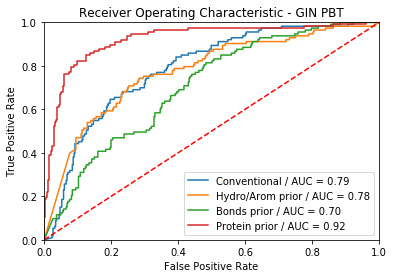

In [15]:
accuracies = [accs1, accs2, accs3, accs4]
acclists = [acclist1, acclist2, acclist3, acclist4]

labels = ["Conventional", "Hydro/Arom prior", "Bonds prior", "Protein prior"]
for idx, ac in enumerate(accuracies):
    fpr, tpr, threshold = metrics.roc_curve(labels1, sigmoid(np.array(ac))[:,1])
    roc_auc = metrics.roc_auc_score(labels1, sigmoid(np.array(ac))[:,1])
    plt.title('Receiver Operating Characteristic - GIN PBT')
    plt.plot(fpr, tpr, label = labels[idx]+' / AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
for acc in acclists:
    rec = []
    pre = []
    for idx, acc_fold in enumerate(acc):
        rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
        pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_fold, axis=1)))
#     print(rec)
    print("%.4f %.4f" % (np.mean(pre), np.mean(rec)))
#     print("%.4f" % np.mean(pre), np.std(pre))

0.9137 0.9023
0.8501 0.9121
0.8509 0.9114
0.8401 0.9114


In [17]:
from collections import Counter
idx_wrong = []
idx_wrong2 = []
for acc in accuracies:
    idx_wrong.append(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    idx_wrong2.extend(([i for i,x in enumerate(labels1 == np.argmax(acc,axis=1)) if x == False]))
    
idx_allwrong  = sorted(list(set(idx_wrong[0])&set(idx_wrong[1])&set(idx_wrong[2])&set(idx_wrong[3])))
print(Counter(Counter(idx_wrong2).values()))
print(len(Counter(idx_wrong2)))
print(idx_allwrong)

Counter({1: 33, 2: 17, 3: 11, 4: 4})
65
[117, 151, 157, 402]


In [19]:
check_list = idx_allwrong
print(np.array(labels1)[check_list])
print((np.array(accs1))[check_list])
print((np.array(accs2))[check_list])
print((np.array(accs3))[check_list])
print((np.array(accs4))[check_list])

[0 1 1 1]
[[ -3.4644959   -1.76377916]
 [ -2.42532754 -34.98254013]
 [ 19.17446518 -13.58734512]
 [  4.35366821  -6.02244282]]
[[  13.28413773   18.22540283]
 [  28.09298325 -165.51908875]
 [ -66.827034   -138.6999054 ]
 [  30.13640213    7.15433788]]
[[ -8.44116879  13.56958199]
 [ 47.83013535 -33.03262329]
 [ 86.94180298   1.60951614]
 [ -8.58943081  -9.59962082]]
[[-14.64434528  12.08301735]
 [ 56.67642212 -89.44985962]
 [ -4.13857555 -63.40364456]
 [ -1.75524855 -15.96564484]]


In [16]:
accuracies = [accs1, accs3, accs2, accs4]
for acc in accuracies:
    print(confusion_matrix(labels1, np.argmax(acc, axis=1)))

[[370  11]
 [ 11 102]]
[[361  20]
 [ 10 103]]
[[361  20]
 [ 10 103]]
[[357  24]
 [ 10 103]]


In [19]:
accs = []
for idx1, acc1 in enumerate(acclists):
    acc_temp = []
    for idx, acc_fold in enumerate(acc1):
        acc_samen = (sigmoid(np.array(acclists[0][idx]))+sigmoid(np.array(acclists[idx1][idx])))/2
        acc_temp.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    accs.append([idx1, np.mean(acc_temp), np.std(acc_temp)])
        
df = pd.DataFrame(accs)
for a in list(df.values):
    print("%.2f+/-%.2f" % (100*a[1],100*a[2]))
rep123=[]
rep124=[]
rep1234=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep123.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep124.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234.append(balanced_accuracy_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print("%.2f+/-%.2f" % (100*np.mean(rep123), 100*np.std(rep123)))
print("%.2f+/-%.2f" % (100*np.mean(rep124), 100*np.std(rep124)))
print("%.2f+/-%.2f" % (100*np.mean(rep1234), 100*np.std(rep1234)))

93.67+/-4.63
93.80+/-4.53
93.18+/-4.43
92.93+/-4.54
93.31+/-4.35
93.31+/-4.35
93.59+/-4.48


/home/jeroen/miniconda3/envs/benchmark_gnn/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


In [22]:
accs = []
for idx1, acc1 in enumerate(acclists):
    acc_temp = []
    rec = []
    pre = []
    for idx, acc_fold in enumerate(acc1):
        acc_samen = (sigmoid(np.array(acclists[0][idx]))+sigmoid(np.array(acclists[idx1][idx])))/2
        rec.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
        pre.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    accs.append([idx1, np.mean(pre), np.mean(rec)])
        
df = pd.DataFrame(accs)
for a in list(df.values):
    print("%.2f %.2f" % (a[1],a[2]))
rep123r=[]
rep124r=[]
rep1234r=[]
rep123p=[]
rep124p=[]
rep1234p=[]
for idx in range(10):
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep123r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep123p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx])))/3
    rep124r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep124p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    acc_samen = (sigmoid(np.array(acclist1[idx]))+sigmoid(np.array(acclist2[idx]))+sigmoid(np.array(acclist3[idx]))+sigmoid(np.array(acclist4[idx])))/4
    rep1234r.append(sklearn.metrics.recall_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
    rep1234p.append(sklearn.metrics.precision_score(lablist1[idx], np.argmax(acc_samen, axis=1).tolist()))
print("%.2f %.2f" % (np.mean(rep123p), np.mean(rep123r)))
print("%.2f %.2f" % (np.mean(rep124p), np.mean(rep124r)))
print("%.2f %.2f" % (np.mean(rep1234p), np.mean(rep1234r)))

0.91 0.90
0.92 0.90
0.88 0.90
0.88 0.90
0.89 0.90
0.89 0.90
0.91 0.90


/home/jeroen/miniconda3/envs/benchmark_gnn/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


In [26]:
accs = []
for idx1, acc1 in enumerate(accuracies):
    pred = []
    acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(acc1)))/2
    print(idx1+1)
    print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

1
[[370  11]
 [ 11 102]]
2
[[371  10]
 [ 11 102]]
3
[[366  15]
 [ 11 102]]
4
[[364  17]
 [ 11 102]]


/home/jeroen/miniconda3/envs/benchmark_gnn/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp


In [27]:
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))
acc_samen = (sigmoid(np.array(accs1))+sigmoid(np.array(accs2))+sigmoid(np.array(accs3))+sigmoid(np.array(accs4)))/4
print(confusion_matrix(labels1, np.argmax(acc_samen, axis=1).tolist()))

[[367  14]
 [ 11 102]]
[[369  12]
 [ 10 103]]
[[369  12]
 [ 11 102]]


/home/jeroen/miniconda3/envs/benchmark_gnn/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in exp
